<a href="https://colab.research.google.com/github/LongNghia/7onez/blob/main/%5Bonly_silhouttte_1.0%5Dfit_textured_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Tái tạo mô hình ba chiều từ dãy ảnh dựa trên kết xuất hình chiếu

Thuật toán:
- Đọc lưới mesh và texture của nó từ file `.obj`. 
- Tạo bộ dữ liệu giả bằng cách kết xuất hình ảnh của lưới mesh đã phủ texture ở nhiều góc nhìn khác nhau.
- Sử dụng thuật toán tối ưu SGD để so khớp một lưới mesh khởi thủy thành hình dạng của vật thể trong bộ dữ liệu giả thông qua kết xuất khả vi hình chiếu của chúng và tìm ra texture cho mô hình bằng cách tìm giá trị màu cho mỗi đỉnh tương ứng với các bộ phận của vật thể trong bộ dữ liệu.

## 0. Cài đặt và thêm các module

In [2]:
import os
import sys
import time
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.11.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k  100  404k    0     0  2075k      0 --:--:-- --:--:-- --:--:-- 17.3M
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-1zzrlojy
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-1zzrlojy
  Running command git checkout -q 2bd65027ca5c3b87b77d4f05b8eacae58d8d106f
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 596 kB 33.0 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.2-cp37-cp37m-linux_x86_64.whl size=30195527 sha256=e1b6eb006641e5

In [3]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.ops import sample_points_from_meshes

import numpy as np
from tqdm.notebook import tqdm

# Các hàm tiện ích để đọc và ghi đối tượng lưới mesh
from pytorch3d.io import load_objs_as_meshes, save_obj
# Các hàm lỗi sẽ dùng. 
# Khoảng cách Chamfer để so sánh kết quả với mô hình gốc
# Mesh edge loss, mesh laplacian smoothing và mesh normal consistency
# để kiểm soát quá trình tái tạo mô hình
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Các hàm và cấu trúc dữ liệu cho việc kết xuất hình ảnh
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)


import sys
import os
sys.path.append(os.path.abspath(''))

Nếu sử dụng Google Colab, lấy các hàm tiện ích để hiển thị kết quả kết xuất dưới dạng lưới hình ảnh:

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-07-13 13:20:04--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-07-13 13:20:05 (38.0 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



### 1. Đọc file mesh và texture
Do sử dụng dữ liệu là ảnh tự tạo từ các mô hình ba chiều có sẵn, nên đây là bước khóa luận chuẩn bị dữ liệu.
Mô hình 3D được lưu trữ gồm file `.obj` chứa lưới mesh và file `.mtl` chứa texture tương ứng của lưới mesh. 

Lấy một mô hình bằng cách fecth từ link

In [5]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2022-07-13 13:20:05--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K   879KB/s    in 0.4s    

2022-07-13 13:20:06 (879 KB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2022-07-13 13:20:06--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[========

In [6]:
# Cài đặt thiết bị
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Đặt đường dẫn
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "bench/bench.obj")
# obj_filename = os.path.join(DATA_DIR, "monitor/monitor.obj")

# Đọc file obj
mesh = load_objs_as_meshes([obj_filename], device=device)

# Chuẩn hóa lưới mesh của mô hình đầu vào bằng việc
# biến đổi affine lên lưới mesh sao cho tâm của lưới mesh ở gốc tọa độ
# và kích thước của lưới mesh nằm vừa trong một khối cầu bán kính bằng 1.
# Việc chuẩn hóa giúp làm tăng tốc độ của thuật toán tối ưu.
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## 2. Tạo bộ dữ liệu ảnh
Bộ dữ liệu là dãy ảnh chụp mô hình ba chiều đầu vào ở những góc nhìn khác nhau. Ở bước này cần khởi tạo một bộ kết xuất (renderer) và bộ đổ bóng (shader) để nội suy chất liệu bề mặt của mô hình. Sử dụng ma trận xoay để xoay mô hình theo nhiều góc nhìn và kết xuất từng ảnh một để có bộ dữ liệu.


In [7]:
# Số góc nhìn vật thể mà ta muốn kết xuất 
num_views = 20
rows = 4
cols = 5

# Tạo một dãy các góc nhìn 
elev = torch.linspace(0, 270, num_views)
azim = torch.linspace(-180, 90, num_views)

# Đặt nguồn sáng ở phía trước vật thể. 
#Mặt trước của vật thể hướng ngược về phía trục z
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])


# Khởi tạo các camera với khoảng cách tới vật thể là 2.7 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Chọn tùy ý một góc nhìn để kết xuất kết quả
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

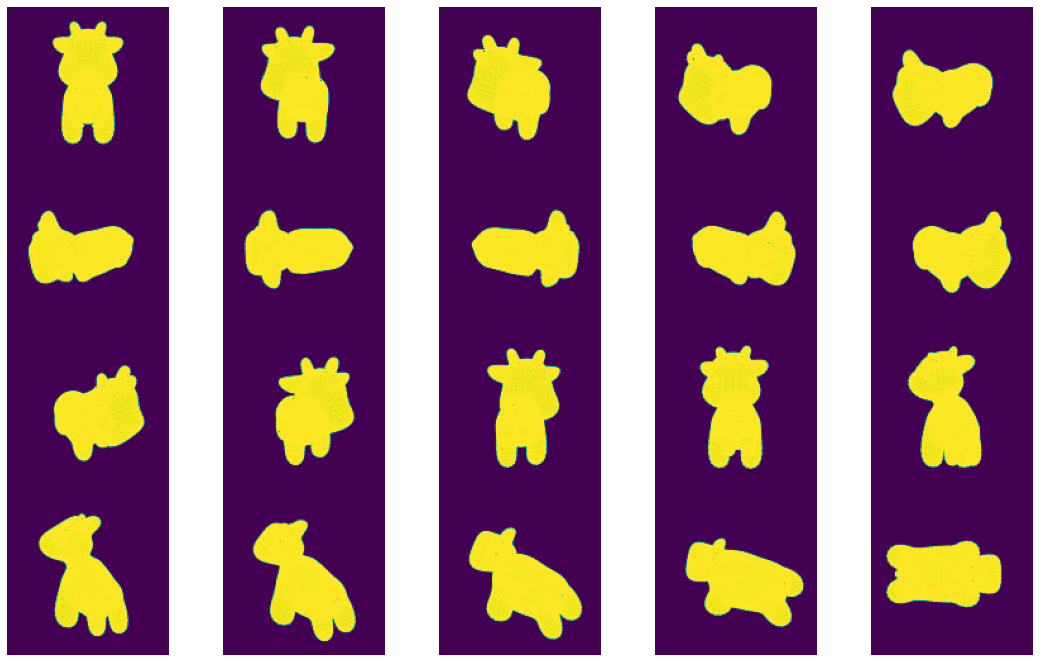

In [8]:
# Thiết lập thông số của raster hóa cho việc kết xuất hình chiếu  
sigma = 1e-4
# Vì sử dụng Soft Rasterize nên thông số làm mờ sigma được đưa vào
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Khởi tạo bộ kết xuất hình chiếu cho vật thể
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Tạo một dãy các lưới mesh là nhân bản của lưới mesh ban đầu và texture của nó
# Dùng để kết xuất ảnh vật thể ở các góc nhìn khác nhau
meshes = mesh.extend(num_views)

# Kết xuất dãy hình chiếu.
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Hiển thị dãy ảnh hình chiếu
image_grid(silhouette_images.cpu().numpy(), rows, cols, rgb=False)
plt.show()

In [9]:
print(target_silhouette[0].shape)

torch.Size([128, 128])


## 3. Dự đoán lưới mesh dựa trên kết xuất hình chiếu

In [10]:
# Các hàm hiển thị kết quả dự đoán lưới và so sánh với ảnh gốc, hàm vẽ đồ thị độ lỗi
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_silhouette[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")
# biểu diễn ba chiều

def show3D(src):
  verts, faces_idx, _ = load_obj(src)
  faces = faces_idx.verts_idx

  # Initialize each vertex to be white in color.
  verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
  textures = TexturesVertex(verts_features=verts_rgb.to(device))

  # Create a Meshes object
  mesh = Meshes(
      verts=[verts.to(device)],   
      faces=[faces.to(device)],
      textures=textures
  )
  return mesh

def plot3D(mesh, name):

  fig = plot_scene({
      name: {
          name: mesh
      }
  },
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
  axis_args=AxisArgs(showgrid=True)
  )
  fig.show()

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


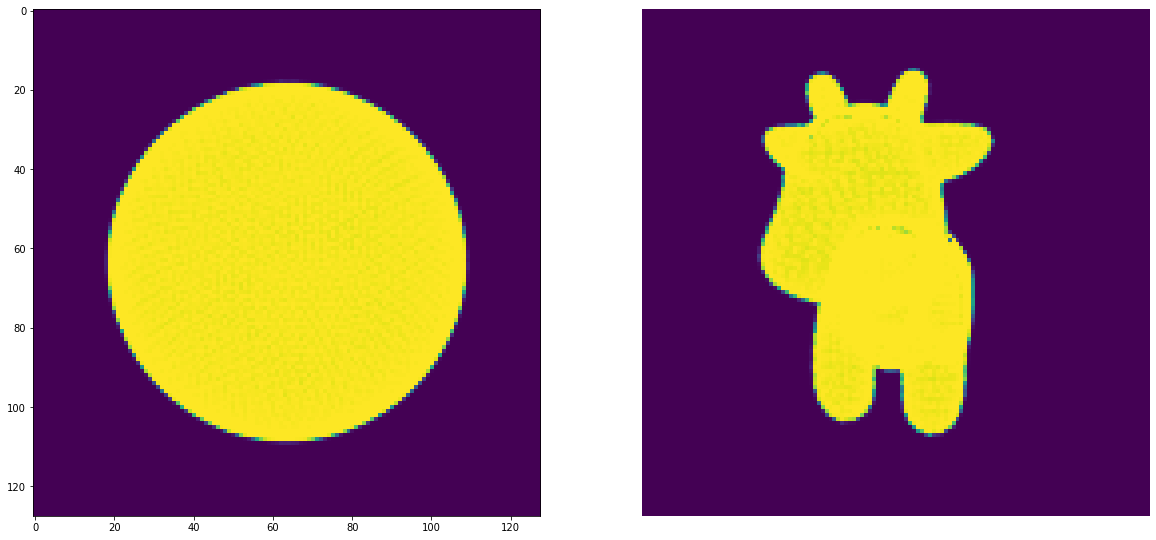

In [11]:
# Khởi tạo một lưới mesh có dạng khối đa diện đều bán kính bằng 1  
src_mesh = ico_sphere(4, device)
visualize_prediction(src_mesh, silhouette=True, 
                     target_image=target_silhouette[1])
plot3D(src_mesh, "source_mesh")


In [12]:
# Cài đặt tham số và khởi tạo một bộ kết xuất mới để kết xuất hình chiếu cho lưới dự đoán
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

In [13]:
# Số góc nhìn dùng để đối sánh ở mỗi vòng lặp của thuật toán tối ưu SGD
num_views_per_iteration = 2
# Số vòng lặp
Niter = 1000
# Chù kỳ vẽ đồ thị hàm mất mát
plot_period = 250

%matplotlib inline

# Tối ưu hóa lưới dự đoán bằng các hàm lỗi đã nêu.
# Đặt trọng số cho từng hàm lỗi và khai báo biến losses để lưu trữ các hàm lỗi
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Hàm cập nhật độ lỗi
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# Mô hình sẽ học cách nắn khối khởi tạo thành vật thể,
# bằng cách offset các đỉnh của khối khởi tạo. 
# SỐ đỉnh của lưới khởi tạo được giữ nguyên trong suốt quá trình
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# Khởi tạo thuật toán tối uu Stochastic Gradient Descent.
# Tốc độ học bằng 1 và momentum là 0.9
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

Viết một vòng lặp cho việc tối ưu và lần lượt làm mịn lưới mesh dự đoán và lựa chọn màu cho khớp với dãy ảnh màu đầu vào.

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



execution time = 28.587932 s


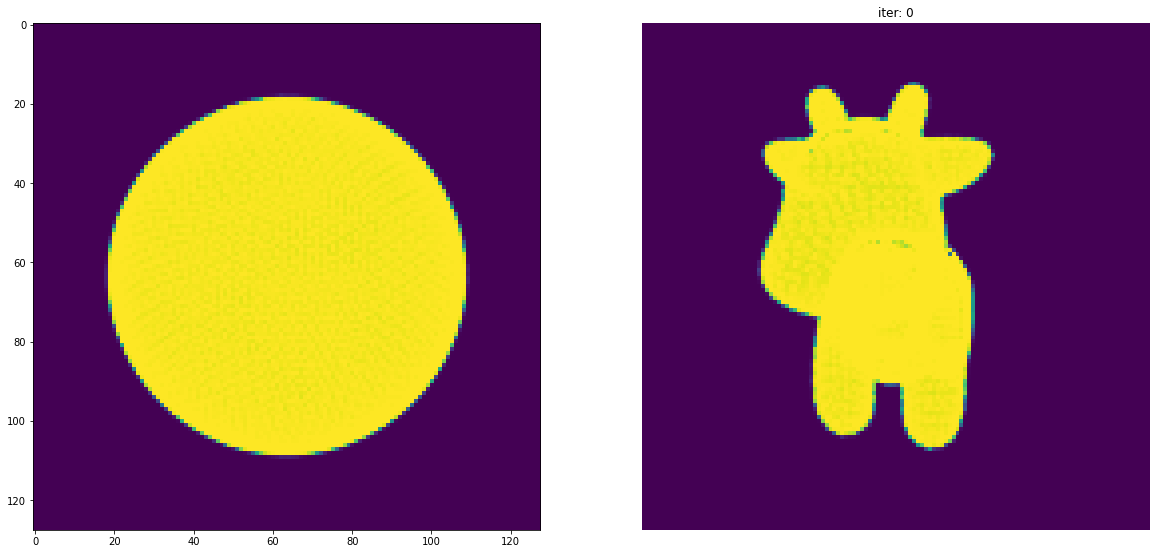

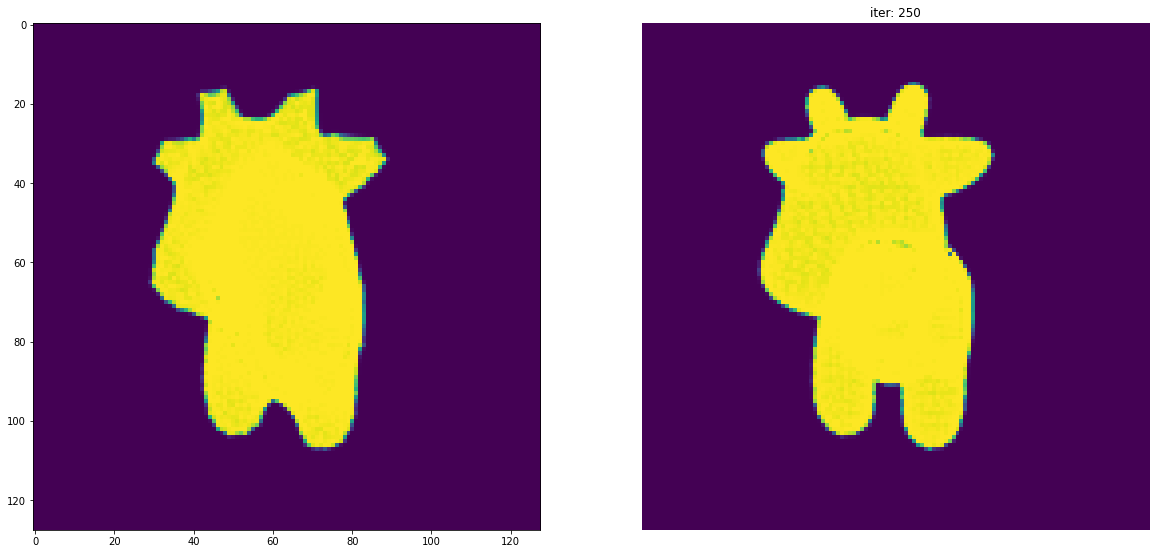

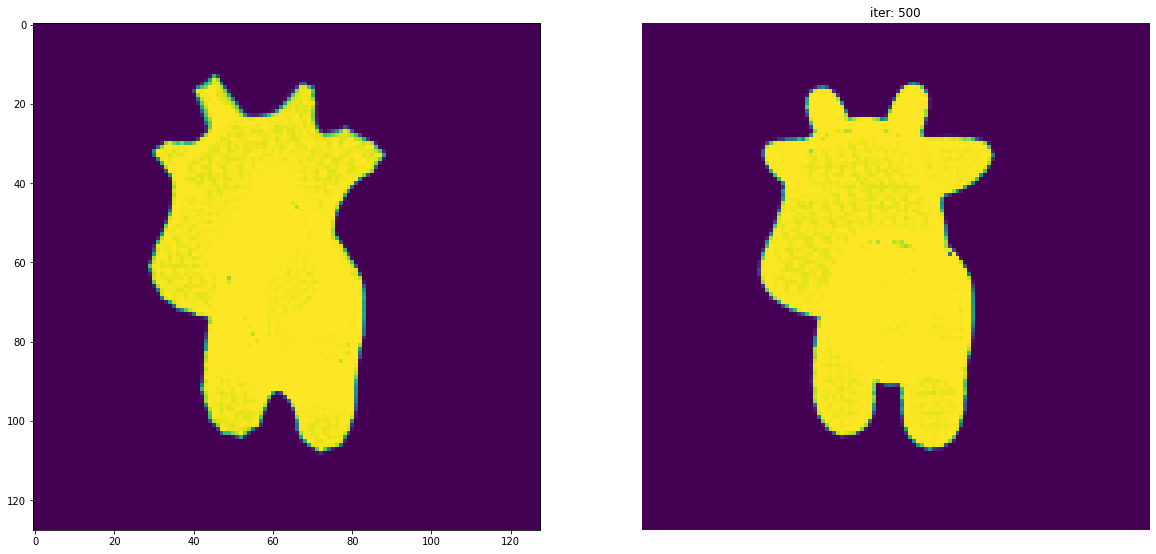

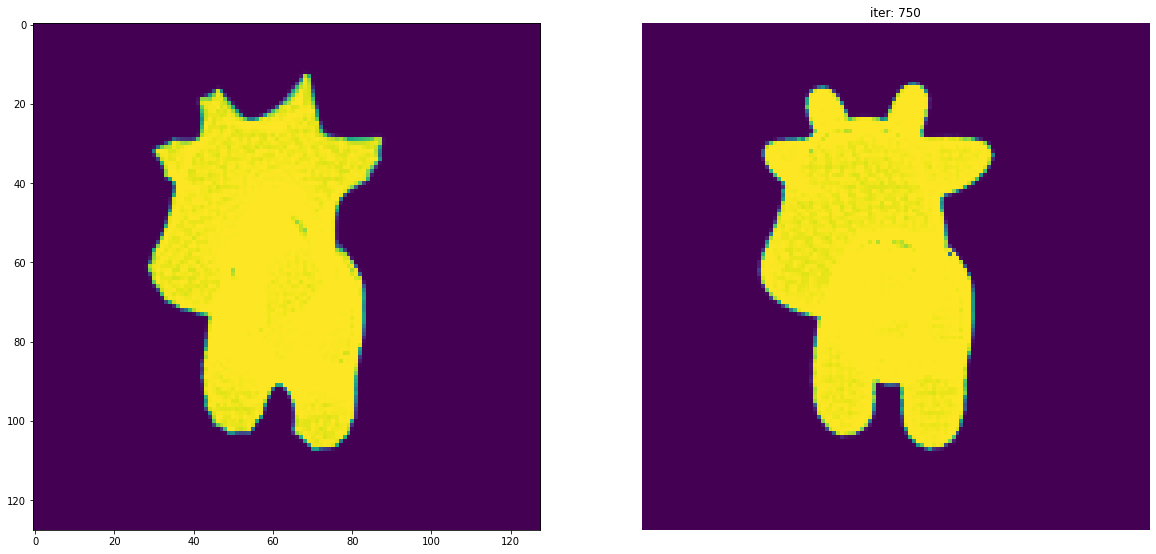

In [14]:
start = time.time()
loop = tqdm(range(Niter))

for i in loop:
    # Khởi chạy thuật toán tối ưu
    optimizer.zero_grad()
    # Nắn lưới mesh bằng cách offset các đỉnh của nó
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Các hàm lỗi để làm mịn và chuẩn hóa lưới mesh dự đoán
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    # Chọn ngẫu nhiên 2 góc nhìn để thực hiện tối ưu.
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        # Tính khoảng cách/độ lỗi căn bặc 2 L2 
        # giữa ảnh hình chiếu của lưới dự đoán được kết xuất và ảnh hình chiếu từ bộ dữ liệu.
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Tổng các độ lỗi đã có trọng số cho từng độ lỗi
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # In ra độ lỗi
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Hiện thị lưới mesh dự đoán
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1])
        
    # Lan truyền ngược các độ lỗi và chuyển sang vòng lặp tiếp theo
    sum_loss.backward()
    optimizer.step()
end = time.time()
print("execution time = %f s" %(end - start))

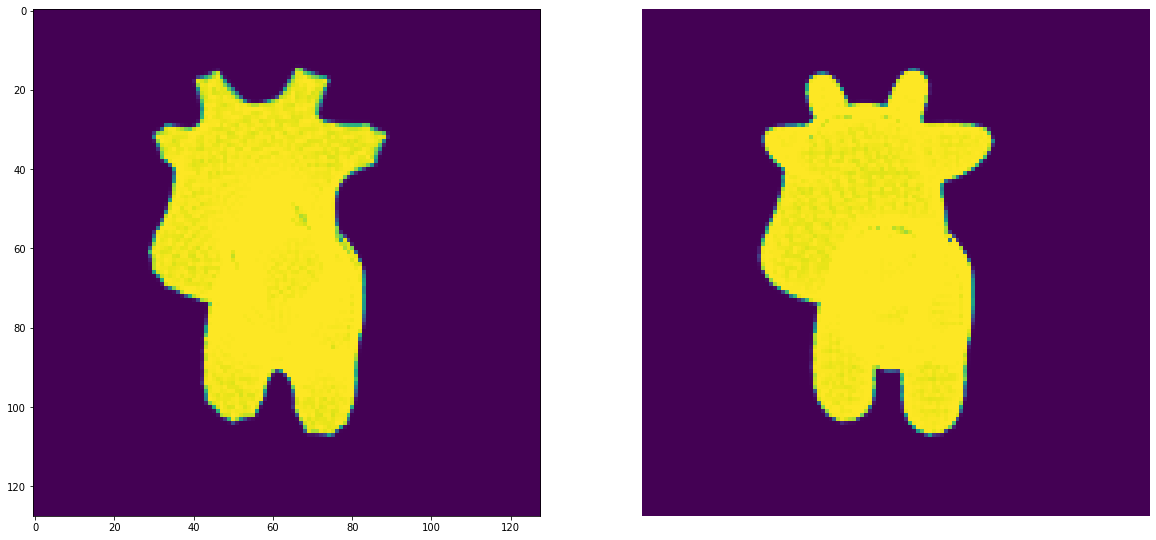

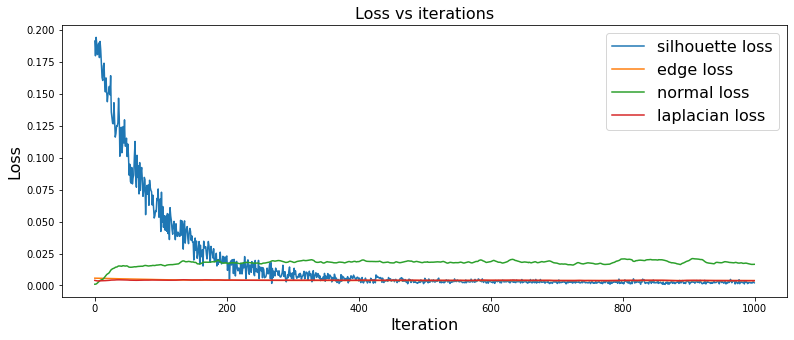

In [15]:
# Hiển thị kết quả cuối cùng
visualize_prediction(new_src_mesh, silhouette=True, 
                     target_image=target_silhouette[1])
plot_losses(losses)

## 4. Lưu lưới mesh dự đoán cuối cùng

In [16]:
# Lưu lại các đỉnh và mặt của lưới mesh dự đoán ở vòng lặp cuối cùng
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Trả lại kích thước ban đầu cho lưới mesh
final_verts = final_verts * scale + center

# Lưu lại lưới mesh dự đoán
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

In [17]:
# biểu diễn kết quả

org_mesh = show3D(obj_filename)
final_model = show3D("final_model.obj")

plot3D(org_mesh,"org_mesh")
plot3D(final_model,"final_model")

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:530: UserWarning:

No mtl file provided



In [18]:
# Tính độ đo Chamfer
tgr_mesh = Meshes(verts = [final_verts],faces = [final_faces])

sample_tgr = sample_points_from_meshes(tgr_mesh, 5000)
sample_src = sample_points_from_meshes(mesh, 5000)
cfd = chamfer_distance(sample_tgr,sample_src)
print(cfd)

(tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>), None)


## 5. Kết luận
Trong source code này, khóa luận đã đi qua các bước đọc file lưới mesh và texture của nó, tạo một bộ dữ liệu giả bằng cách kết xuất hình ảnh của mô hình vật thể ở các góc nhìn khác nhau. Thiết lập thuật toán tối ưu để nắn một lưới mesh theo hình dạng của vật thể từ bộ dữ liệu dựa trên độ lỗi của hình chiếu, sau đó thêm vào độ lỗi của ảnh màu RGB, giúp dự đoán lưới mesh và cả texture của nó.